In [1]:
"""
  Module: Iterative Solvers
  Author: Inas KEDIM
"""
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

def CG(A, b, tol, maxit, ortho = True):
    """
    Conjugate Gradient Algorithm
        CG solves the symmetric positive definite linear system
            A x  = b
        A     : n-by-n symmetric and positive definite matrix
        b     : n dimensional right hand side vector
        maxit : maximum number of iterations
        tol   : error tolerance on the residual
    """
    flag = 0                      # initialize a flag variable to check if the algorithm converged
    x = np.zeros_like(b)          # initialize the current approximation to a zero vector
    r = b                         # set the initial residual to b (x0 = 0)
    p = np.copy(r)                         # set the initial search direction to b
    rs_old = np.dot(r, r)         # compute the initial squared residual
    nrmb = np.linalg.norm(b)
    beta = 0
    alpha_old = 1
    quadrafunc = 0
    T = np.zeros((maxit,maxit))
    V = np.zeros((n,maxit))
    V[:,0] = r / np.sqrt(rs_old)
    print('iter', '      quadrafunc','   p.T A p', '   res', '       beta')
    for i in range(maxit - 1):
        if ortho:
            if i == 0:
                R = np.array([r/(rs_old**0.5)]).T
            else:
                R = np.append(R, np.array([r/(rs_old**0.5)]).T, axis=1)
        q = A.dot(p)
        curvature = np.dot(p, q)
        alpha = rs_old / curvature      # compute the step size
        x = x + alpha * p               # update the current approximation x
        r = r - alpha * q               # update the residual
        # Heisnberg matrix
        T[i,i] = (1 / alpha) + (beta / alpha_old)
        # Re orthogonalisation
        if ortho:
            r = r - np.dot(R,np.dot(R.T,r))

        rs_new = np.dot(r, r)           # compute the new squared residual
        V[:,i + 1] = ((-1)**(i + 1)) * (r / np.sqrt(rs_new))
        quadrafunc = quadrafunc - 0.5 * (rs_old ** 2 / curvature)
        res = np.sqrt(rs_new) / nrmb
        beta = (rs_new / rs_old)
        beta_ritz = np.sqrt(beta) / alpha
        print('{:4d}  {:15.5e} {:10.1e} {:10.1e} {:10.1e}'.format(i, quadrafunc, curvature, res, beta_ritz))
        if  res < tol :
            lambda_ , eignvect = np.linalg.eigh(T[:i + 1,:i + 1])
            j = 0
            #l = 0
            #print(len(lambda_))
            for v_p in lambda_:
                #l = l + 1
                #print('{:4d} {:15.5e} {:10.1e}'.format(l, v_p, abs(beta_ritz * eignvect[i][j]) / v_p))
                if abs(beta_ritz * eignvect[i][j]) / v_p > 1e-2 :
                     eignvect= np.delete(eignvect, j, axis=1)
                     lambda_= np.delete(lambda_, j)
                else:
                    j = j + 1
            #print(lambda_)
            print(len(lambda_))

            return lambda_ , V[:,:i+1] @ eignvect, x, np.sqrt(rs_new) / nrmb, i, flag

        p = r + beta * p  # update the search direction
        T[i,i+1] = np.sqrt(beta) / alpha
        T[i+1,i] = np.sqrt(beta) / alpha
        rs_old = rs_new
        alpha_old = alpha
    lambda_ , eignvect = np.linalg.eig(T)
    if res > tol:
        flag = 1
    return lambda_ , V @ eignvect, x, np.sqrt(rs_new) / nrmb, i, flag




def Lanczos (A, x_0, b, tol, maxit, ortho = False):
    """
    Lanczos algorithm
        Lanczos solves the symmetric positive definite linear system
            A x  = b
        A     : n-by-n symmetric and positive definite matrix
        b     : n dimensional right hand side vector
        maxit : maximum number of iterations
        tol   : error tolerance on the residual
    """
    flag = 0
    res = b - A.dot(x_0)
    nrmb = np.linalg.norm(b)
    beta0 = np.linalg.norm(res)
    quadrafunc = 0
    v = res / beta0
    V = np.zeros((n,maxit))
    V[:,0] = v
    T = np.zeros((maxit,maxit))
    print('iter', '      quadrafunc','   beta', '   res')
    for i in range (maxit - 1):
        if i > 0:
            w = A.dot(v) - beta * V[:,i-1]
        else:
            w = A.dot(v)
        alpha = np.dot(w, v)
        w = w - alpha * v
        T[i][i] = alpha
        s = np.zeros(i + 1)
        s[0] = beta0
        y =  np.linalg.solve(T[:i+1,:i+1], s)
        x = x_0 + V[:,:i+1].dot(y)
        beta = np.linalg.norm(w)
        res = b - A.dot(x)
        resi = np.linalg.norm(res) / nrmb
        quadrafunc = -0.5 * np.dot((b + res), x)
        print('{:4d} {:13.1e} {:10.1e} {:10.1e}'.format(i, quadrafunc, beta, resi))

        if resi < tol :
            return x, i, resi, flag, T[:i+1,:i+1]
        v = w / beta
        T[i][i + 1] = beta
        T[i + 1][i] = beta

        if ortho:
            v = v - np.dot(V[:, :i+1], np.dot(V[:, :i+1].T, v))
        V[:,i + 1] = v

    if resi > tol:
        flag = 1
    return x, i, resi, flag


iter       quadrafunc    p.T A p    res        beta
   0     -1.29696e+01    3.5e+01    1.4e+01    1.7e+01
   1     -3.99642e+01    7.0e+05    2.2e+01    1.7e+02
   2     -5.67710e+01    6.0e+06    1.3e+01    2.6e+02
   3     -1.00011e+02    3.5e+05    5.5e+00    2.6e+01
   4     -1.33773e+02    1.3e+04    5.5e+00    1.4e+01
   5     -1.52186e+02    2.2e+04    9.9e+00    4.4e+01
   6     -1.80158e+02    1.5e+05    5.0e+00    2.7e+01
   7     -2.49172e+02    4.1e+03    4.8e+00    5.2e+00
   8     -3.14188e+02    3.6e+03    3.9e+00    4.3e+00
   9     -3.78833e+02    1.7e+03    3.7e+00    3.4e+00
  10     -4.33481e+02    1.6e+03    4.3e+00    4.4e+00
  11     -5.25382e+02    1.6e+03    4.0e+00    2.8e+00
  12     -7.03731e+02    6.5e+02    3.9e+00    1.3e+00
  13     -8.17021e+02    9.8e+02    4.4e+00    2.3e+00
  14     -9.87869e+02    9.8e+02    3.0e+00    1.2e+00
  15     -1.04312e+03    7.1e+02    3.3e+00    2.7e+00
  16     -1.19369e+03    3.6e+02    2.5e+00    8.4e-01
  17     -1.3

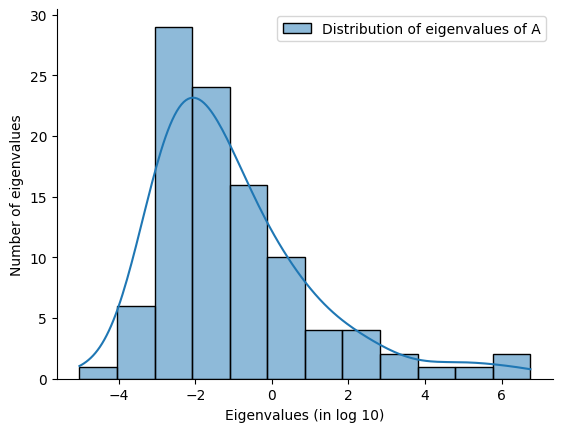

In [3]:
if __name__ == '__main__':
    n = 100 # dimension de la matrice
    # Data Assimilation Set-Up
    #H matrix
    m = 8        # Number of observation
    Hmat = np.eye(n)
    inds=np.random.permutation(m)
    Hmat = Hmat[:,inds]
    Hmat = Hmat.T
    #R matrix
    Imat = np.eye(n)
    sigma_r = 0.3
    Rinv = sigma_r*np.eye(m)
    RinvH  = np.matmul(Rinv, Hmat)
    #Hessian
    HtRinvH = np.matmul(Hmat.T, RinvH)

    #B matrix
    B12 = np.random.rand(n,n)
    B = np.dot(B12, B12.T)
    A = np.linalg.inv(B) + HtRinvH

    # Starting point for CG
    x_0 = np.zeros(n)


    b= np.random.rand(n)
    maxit = 2000
    tol   = 1e-6
    [ritz_val , ritz_vect, cg_sol, error, iter, flag] = CG(A, b, tol, maxit)

    # Eigenvalues of A
    lambda0 , eignvect0 = np.linalg.eigh(A)
    eigenvalues = np.log(lambda0)
    # Dessiner la distribution des valeurs propres
    sns.histplot(eigenvalues, kde = True, label = "Distribution of eigenvalues of A" )
    sns.despine()
    plt.legend()
    plt.xlabel("Eigenvalues (in log 10)")
    plt.ylabel("Number of eigenvalues")
    plt.show()

